In [50]:
# Import data from /dataset/
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedKFold, KFold
from sklearn.kernel_ridge import KernelRidge
import pandas as pd

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')

In [13]:
df.head()

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words,score_compound,sentiment
0,1532325760148590593,@xbresson British Alps :-),replied_to,62044012,False,0,0,1,2,33022,3383,5246,359,"['british', 'alps']",0.0000,neutral
1,1312410689059913731,RT @Aistats2020: Videos presentations of paper...,retweeted,1290762290224984064,False,52,0,0,0,17570,541,703,222,"['videos', 'presentations', 'papers', 'keynote...",0.0000,neutral
2,1564467011781926913,I hope I would be able to talk more about this...,quoted,3363584909,False,1,0,0,3,65506,113,15406,856,"['hope', 'would', 'able', 'talk', 'balcony', '...",0.4862,neutral
3,1473395733344788481,RT @dlbcnai: Keynote by Joan Bruna (@joanbruna...,retweeted,1071640880,False,35,0,0,0,21847,555,1346,264,"['keynote', 'joan', 'bruna', 'geometric', 'dee...",0.3612,neutral
4,1611495430843502593,@annargrs @Michael_J_Black @AllenHW0 @CSProfKG...,replied_to,48008938,False,0,0,1,5,427851,582,12949,6488,"['process', 'science', 'relies', 'much', 'basi...",-0.3182,neutral


In [14]:
# Count the number of dataset
df.count()

id                    8000
text                  8000
type                  8000
author_id             8000
possibly_sensitive    8000
retweet_count         8000
quote_count           8000
reply_count           8000
like_count            8000
followers_count       8000
following_count       8000
tweet_count           8000
listed_count          8000
words                 8000
score_compound        8000
sentiment             8000
dtype: int64

In [15]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

In [16]:
df_pos = df[df.sentiment == 'positive']
df_neu = df[df.sentiment == 'neutral']
df_neg = df[df.sentiment == 'negative']


num_total = len(df)
num_pos = len(df_pos)
num_neu = len(df_neu)
num_neg = len(df_neg)

print(f"Num. positive tweets: {num_pos} ({num_pos/num_total*100:.2f}%)")
print(f"Num. negative tweets: {num_neg} ({num_neg/num_total*100:.2f}%)")
print(f"Num. neutral tweets: {num_neu} ({num_neu/num_total*100:.2f}%)")


Num. positive tweets: 2228 (27.85%)
Num. negative tweets: 482 (6.02%)
Num. neutral tweets: 5290 (66.12%)


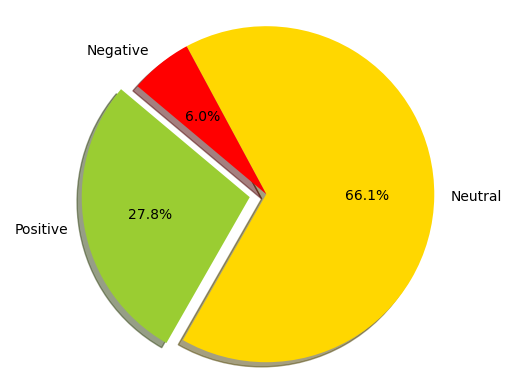

In [17]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot the sentiments in a pie chart

labels = ['Positive', 'Neutral', 'Negative']

sizes = [num_pos, num_neu, num_neg]

colors = ['yellowgreen', 'gold', 'red']

explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


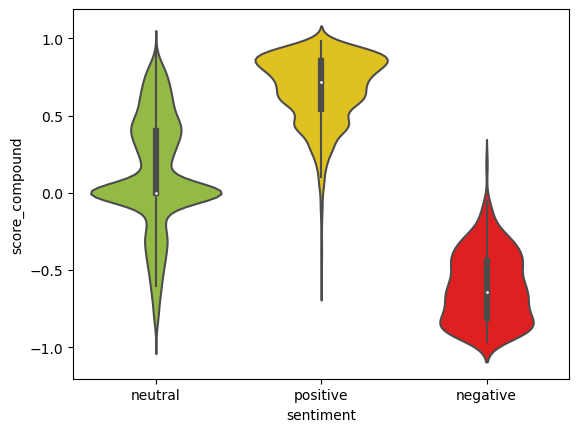

In [18]:
# Import seaborn
import seaborn as sns

# Plot violinplot

plt.close('all')

sns.violinplot(data=df, x='sentiment', y='score_compound', palette=colors)
plt.show()

In [19]:
from sentence_transformers import SentenceTransformer

# Specify the model name
# I downloaded in models directory three models: 
# all-MiniLM-L6-v2(Fastest but smalles), stsb-roberta-base-v2(middle), and stsb-mpnet-base-v2(Slowest, but best performance)

name = 'all-MiniLM-L6-v2'

# Load the SentenceTransformer model
#model = SentenceTransformer(f'models/{name}')
model = SentenceTransformer(f'sentence-transformers/{name}')



Extra link for model rankings:
https://www.sbert.net/docs/pretrained_models.html

In [20]:
# List of sentences to get embeddings for
sentences = list(df.words_str.values)

# Get the sentence embeddings
sentence_embeddings = model.encode(sentences)

Regression

In [21]:
#define some functions for plotting purposes

def plot_y_continous(y, bins=10, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.hist(y, bins=bins)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

def plot_scatter(x, y,  show=True, x_label=None, y_label=None,  title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.scatter(x,y)
    if isinstance(title, str):
        ax.set_title(title)
    if isinstance(x_label, str):
        ax.set_xlabel(x_label)
    if isinstance(y_label, str):
        ax.set_ylabel(y_label)
    plt.tight_layout()
    if show: plt.show()
    

In [22]:
#create X (feature matrix) and y (targets)
X = sentence_embeddings
y = df.score_compound.values
print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (8000, 384)
y: (8000,)


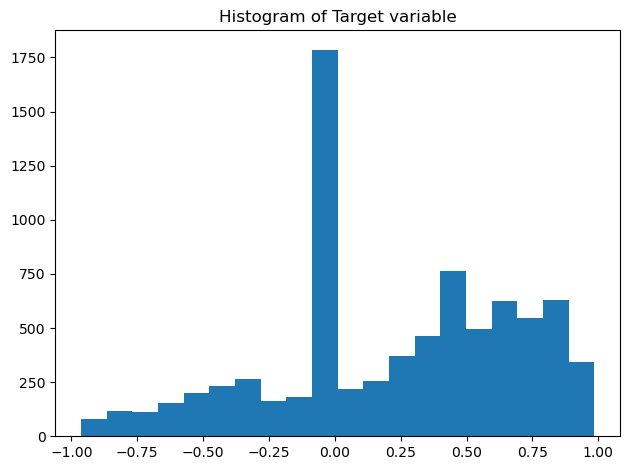

In [23]:
plt.close('all')
plot_y_continous(y, bins=20, title='Histogram of Target variable')

In [24]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import numpy as np

In [25]:
#split X and y for training and validation purposes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

#create our linear regression model
reg = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

In [26]:
reg = reg.fit(X_train, y_train)

In [27]:
# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")   



Split: train
	RMSE: 0.33
	MAE: 0.26
	R2: 0.48

Split: valididation
	RMSE: 0.34
	MAE: 0.27
	R2: 0.40


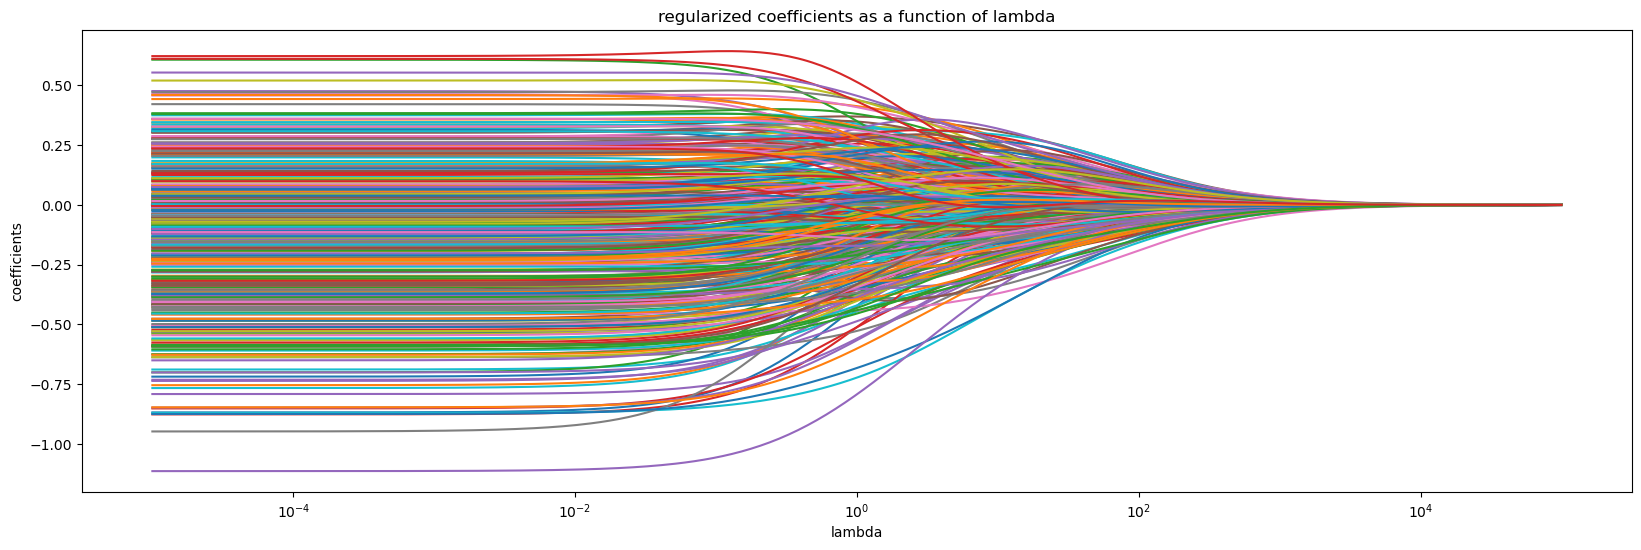

In [28]:
#ridge regression and lasso regression.
#Add cross validation k=10
import warnings
warnings.filterwarnings('ignore')
#set num parameter of logspace lower so it does not take too much time, optimums then become less accurate
lambdas = np.logspace (-5, 5 , 300)

def plot_regularized_coeffs(reg,lambdas):
        params = [None for _ in range(len(lambdas))] #initialize params/coeffs list
        for i,lambda_ in enumerate(lambdas):
                reg.set_params(alpha=lambda_)
                reg.fit(X_train,y_train)
                params[i] = reg.coef_

        # Plot coefficients with varying lambda
        plt.figure(figsize=(20, 6))
        plt.subplot()
        ax = plt.gca()
        ax.plot(lambdas, params)
        ax.set_xscale("log")
        plt.xlabel("lambda")
        plt.ylabel("coefficients")
        plt.title(f"regularized coefficients as a function of lambda")
        plt.axis("tight") 
        plt.show()
reg = linear_model.Ridge()
plot_regularized_coeffs(reg,lambdas)

Optimal alpha: 2.078383818579755

Split: train
	RMSE: 0.33
	MAE: 0.26
	R2: 0.46

Split: valididation
	RMSE: 0.34
	MAE: 0.27
	R2: 0.40


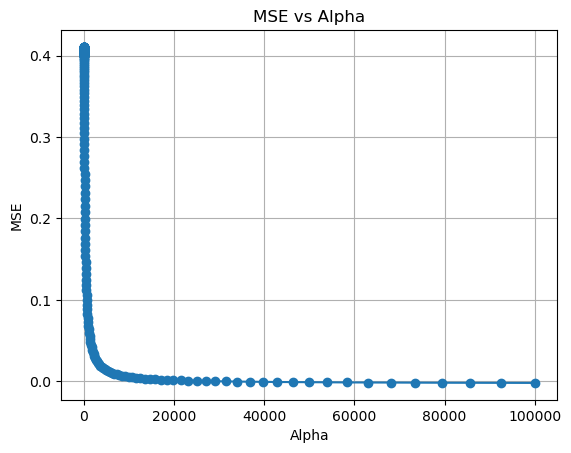

In [29]:
from sklearn.model_selection import GridSearchCV


ridge = linear_model.Ridge()
#Ridge regression with 10-fold CV to find optimal alpha
reg = GridSearchCV(ridge, param_grid = {'alpha': lambdas},cv=10)
reg.fit(X_train,y_train)
### gives us best alpha
print("Optimal alpha:", reg.best_params_['alpha'])
# Evaluate our predictor quantitatively


for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")   


# Get the hyperparameters and corresponding MSE values
alphas = reg.cv_results_['param_alpha'].data
mse_values = reg.cv_results_['mean_test_score']

# Plot the MSE values against the alpha values
plt.plot(alphas, mse_values, marker='o')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE vs Alpha')
plt.grid(True)
plt.show()


In [30]:

lasso = linear_model.Lasso()
#Lasso regression with 10-fold CV to find optimal alpha
reg = GridSearchCV(lasso, param_grid = {'alpha': lambdas},cv=10)
reg.fit(X_train,y_train)
###gives us best alpha
print("Optimal alpha:", reg.best_params_['alpha'])

for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")   


Optimal alpha: 5.878016072274912e-05

Split: train
	RMSE: 0.33
	MAE: 0.26
	R2: 0.47

Split: valididation
	RMSE: 0.34
	MAE: 0.27
	R2: 0.40


In [51]:
cv = RepeatedKFold(n_splits = 10, n_repeats=3, random_state= 42)
model = linear_model.Ridge()
lambdas = np.logspace (-5, 5 , 300)
reg = GridSearchCV(estimator = model, param_grid = {'alpha': lambdas},n_jobs = -1,cv=cv, scoring = 'neg_mean_absolute_error')
reg.fit(X_train,y_train)
print("Optimal alpha:", reg.best_params_['alpha'])

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")

Optimal alpha: 0.7637357916378011

Split: train
	RMSE: 0.33
	MAE: 0.26
	R2: 0.47

Split: valididation
	RMSE: 0.34
	MAE: 0.27
	R2: 0.40


In [32]:
#plot the histogram of learnt weights w_i 
plot_y_continous(reg.coef_, bins=5, title='Histogram of Parameters (w) learnt')

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

For test data

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
sentences_test = list(df_test.words_str.values)
X_test = model.encode(sentences_test)
y_hat = reg.predict(X_test)

In [ ]:
# Save the results with the format <TEAM_ID>__<SPLIT>_reg_pred.npy
import os

directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__reg_pred.npy'), y_hat)

Classification

In [33]:
from sklearn import linear_model
from sklearn import preprocessing

In [34]:
def plot_y_discrete(y, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    sns.countplot(x=y, palette=colors, ax=ax)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

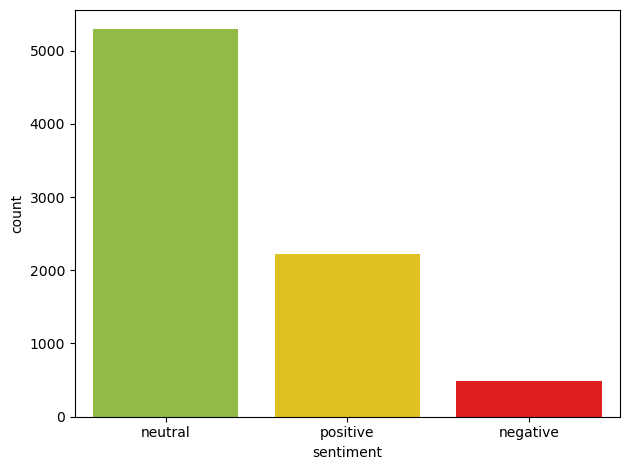

In [35]:
plot_y_discrete(df.sentiment)

In [36]:
X = sentence_embeddings
y_text = df.sentiment.values
le = preprocessing.LabelEncoder()
le.fit(y_text)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y =le.transform(y_text)
print(f"X: {X.shape}")
print(f"y: {y.shape} {np.unique(y)}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]
clf = linear_model.LogisticRegression(penalty=None, 
                                      dual=False, 
                                      tol=0.0001, 
                                      C=1.0, 
                                      fit_intercept=True, 
                                      intercept_scaling=1, 
                                      class_weight=None, # None, balanced
                                      random_state=None, 
                                      solver='lbfgs', 
                                      max_iter=1000, 
                                      multi_class='auto', 
                                      verbose=0, 
                                      warm_start=False, 
                                      n_jobs=None, 
                                      l1_ratio=None
                                     )
linear_model.LogisticRegression

Original classes ['negative' 'neutral' 'positive']
Corresponding numeric classes [0 1 2]
X: (8000, 384)
y: (8000,) [0 1 2]


sklearn.linear_model._logistic.LogisticRegression

In [37]:
clf = clf.fit(X_train, y_train)

In [38]:
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))


Split: train
              precision    recall  f1-score   support

           0       0.75      0.53      0.62       395
           1       0.83      0.91      0.87      4200
           2       0.78      0.65      0.71      1805

    accuracy                           0.82      6400
   macro avg       0.79      0.70      0.73      6400
weighted avg       0.81      0.82      0.81      6400


Split: validation
              precision    recall  f1-score   support

           0       0.45      0.36      0.40        87
           1       0.83      0.89      0.86      1090
           2       0.70      0.60      0.64       423

    accuracy                           0.78      1600
   macro avg       0.66      0.61      0.63      1600
weighted avg       0.77      0.78      0.77      1600



Linear Discriminant Analysis

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()

clf = clf.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))
    


Split: train
              precision    recall  f1-score   support

           0       0.57      0.54      0.56       395
           1       0.82      0.90      0.86      4200
           2       0.79      0.62      0.69      1805

    accuracy                           0.80      6400
   macro avg       0.73      0.69      0.70      6400
weighted avg       0.80      0.80      0.80      6400


Split: validation
              precision    recall  f1-score   support

           0       0.43      0.46      0.44        87
           1       0.82      0.89      0.86      1090
           2       0.75      0.58      0.65       423

    accuracy                           0.79      1600
   macro avg       0.67      0.64      0.65      1600
weighted avg       0.78      0.79      0.78      1600



In [42]:
clf = QuadraticDiscriminantAnalysis()

clf = clf.fit(X_train, y_train)


# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))


Split: train
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       395
           1       0.71      0.99      0.83      4200
           2       0.99      0.04      0.07      1805

    accuracy                           0.73      6400
   macro avg       0.88      0.68      0.62      6400
weighted avg       0.80      0.73      0.62      6400


Split: validation
              precision    recall  f1-score   support

           0       0.20      0.01      0.02        87
           1       0.68      1.00      0.81      1090
           2       0.88      0.02      0.03       423

    accuracy                           0.68      1600
   macro avg       0.59      0.34      0.29      1600
weighted avg       0.71      0.68      0.56      1600



In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
sentences_test = list(df_test.words_str.values)
X_test = model.encode(sentences_test)
y_hat = clf.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_clf_pred.npy

directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__clf_pred.npy'), y_hat)